In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import mutual_info_regression as MIR

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor

In [4]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#d94801','white','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['white','gray']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c']
cml = sns.blend_palette(colors, n_colors=256, as_cmap=True)

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [5]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [6]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
m_df= male_df.groupby(['age','uuid']).mean()

## arrange data
female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]
f_df= female_df.groupby(['age','uuid']).mean()

# for female:
f_df= female_df.groupby(['age','uuid']).mean()
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4','e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33']
f_df.reset_index(inplace=True)
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid'], inplace=True)

In [7]:
# use only common ages
f_ages = f_df.index.get_level_values('age').unique().to_numpy()
m_ages = m_df.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))
if 90 in cages:
    cages.remove(90)
    
m_data = m_df.loc[m_df.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_df.loc[f_df.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

data=pd.concat([m_data,f_data])

# use the same number of mice per age - only age 80

# Get indices of rows where age is 80
indices = m_data[m_data.index.get_level_values('age') == 80].index
# Choose a random index
np.random.seed(0)
random_index = np.random.choice(indices)
# Remove the row with the selected index
m_data = m_data.drop(random_index)

/tmp/ipykernel_7576/244619805.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_data['sex'] = 'm'
/tmp/ipykernel_7576/244619805.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_data['sex'] = 'f'


In [8]:
#average and normalize male
avg_m_df = m_data.groupby(['age']).mean()
# normalize the data
m_norm = mm_norm_col(m_data)
avg_m_norm = mm_norm_col(avg_m_df)

#average and normalize female
avg_f_df = f_data.groupby(['age']).mean()
# normalize the data
f_norm = mm_norm_col(f_data)
avg_f_norm = mm_norm_col(avg_f_df)
data=pd.concat([m_data,f_data])

In [9]:

pc = PCA(n_components=12)
pcs = pc.fit_transform(data)

temp_data = pd.DataFrame(pcs)
temp_data['sex'] = data.index.get_level_values('sex')
temp_data['age'] = data.index.get_level_values('age')
temp_data.set_index(['age','sex'],inplace=True)

data=temp_data.copy()


In [10]:
# choose a model for decoder
#clf = svm.SVC(kernel='linear') 
clf = RandomForestClassifier(n_estimators = 100)
#from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression(random_state=0)
# choose cross validation scheme
cv = LeaveOneOut()
#number of iterations for shuffle
it=100

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

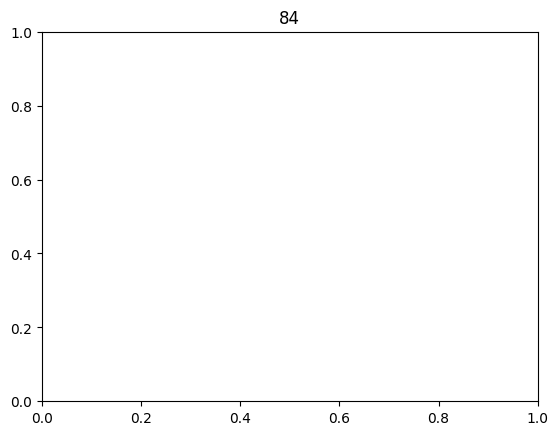

In [11]:
sh_ages=[]
age2=[]
acc=[]
sh_acc=[]
for age,_df in enumerate(data.groupby('age')):
    #ages.extend(_df[1].index.get_level_values('remapped_bins').to_numpy())
    age2.append(_df[0])
    x = _df[1].to_numpy()
    #x = np.log(x + 1e-6)
    plt.title(str(_df[0]))
    y=_df[1].index.get_level_values('sex')
    y_pred = cross_val_predict(clf, x, y, cv=cv)
    acc.append(np.mean(cross_val_score(clf, x, y, cv=cv)))
    for i in tqdm(range(it)):
        sh_ages.append(_df[0])
        ysh_temp=np.random.permutation(y)
        sh_acc.append(np.mean(cross_val_score(clf, x, ysh_temp, cv=cv)))

In [12]:
# create df for plotting
df_sh = pd.DataFrame()
df_sh['acc']=sh_acc
df_sh['ages'] = sh_ages

df = pd.DataFrame()
df['acc']=acc
df['ages'] = age2

(array([  0.,  50., 100.]),
 [Text(0.0, 0, '0'), Text(50.0, 0, '50'), Text(100.0, 0, '100')])

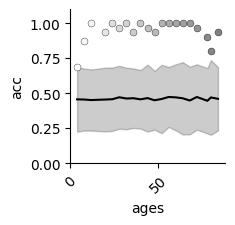

In [13]:
fig, ax = plt.subplots(figsize=(2, 2))
#sns.violinplot(data=df_sh, x="ages", y="acc", ax=ax, color='gray')
sns.lineplot(data=df_sh, x="ages", y="acc", ax=ax, color='black', estimator='mean', errorbar=('sd', 2))
#sns.pointplot(data=df, x="ages", y="acc",
              #xticklabels=1,
              #dodge=0, 
#              join=False, 
#              ax=ax, 
#              scale=1,
#              hue='ages',
 #             palette='Blues',
              #edgecolor='gray',
              #linewidth=0.3
 #            )
#sns.lineplot(data=df, x="ages", y="acc", ax=ax, color='gray')
sns.lineplot (data=df, x='ages', y='acc', 
              markers=True, 
              marker='o',
              markersize=5,
              palette = cma,
              hue='ages',
              linestyle='-',
              markeredgecolor='black', 
              markeredgewidth=0.25,
             legend=False)
plt.ylim([0.0,1.1])
plt.legend([],[], frameon=False)
sns.despine()
plt.xticks(rotation=45)

In [14]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'fvm_sex_decoder_RF.pdf', bbox_inches='tight')